# rio-tiler-mosaic custom pixel selection

Examples using defaults `pixel_selection` methods and how to create customs ones

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [22]:
from rio_tiler.landsat8 import tile as tiler

from rio_tiler_mosaic.mosaic import mosaic_tiler
from rio_tiler_mosaic.methods import defaults

from rio_tiler_mosaic.methods.base import MosaicMethodBase

from rio_tiler.utils import array_to_image, get_colormap, linear_rescale, expression as expressionTiler
from rio_tiler.profiles import img_profiles
from rio_color.operations import parse_operations
from rio_color.utils import scale_dtype, to_math_type

from rasterio.plot import reshape_as_image

### We use landsat 8 product ID and rio_tiler.landsat8.tile handler

In [15]:
assets = ["LC08_L1TP_014028_20190704_20190705_01_RT", "LC08_L1TP_015028_20190609_20190619_01_T1"]
x = 151
y = 183
z = 9
color_formula = "gamma RGB 3.5, saturation 1.7, sigmoidal RGB 15 0.35"

### FirstMethod: Fill with the first value avialable

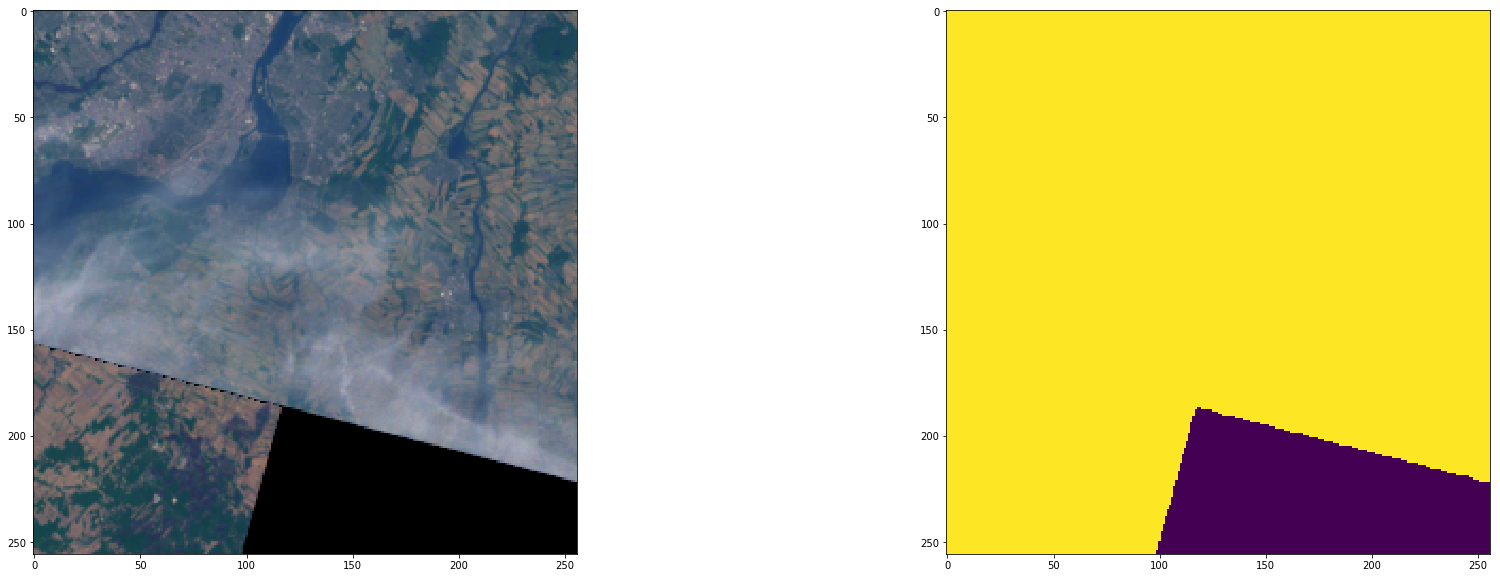

In [14]:
tile, mask = mosaic_tiler(
    assets,
    x,
    y,
    z,
    tiler,
)

for ops in parse_operations(color_formula):
    tile = scale_dtype(ops(to_math_type(tile)), np.uint8)

fig = figure(figsize=(30, 10))

ax = fig.add_subplot(1, 2, 1)
ax.imshow(reshape_as_image(tile))

ax = fig.add_subplot(1, 2, 2)
ax.imshow(mask)

### MeanMethod: Get the mean from all the stack of data

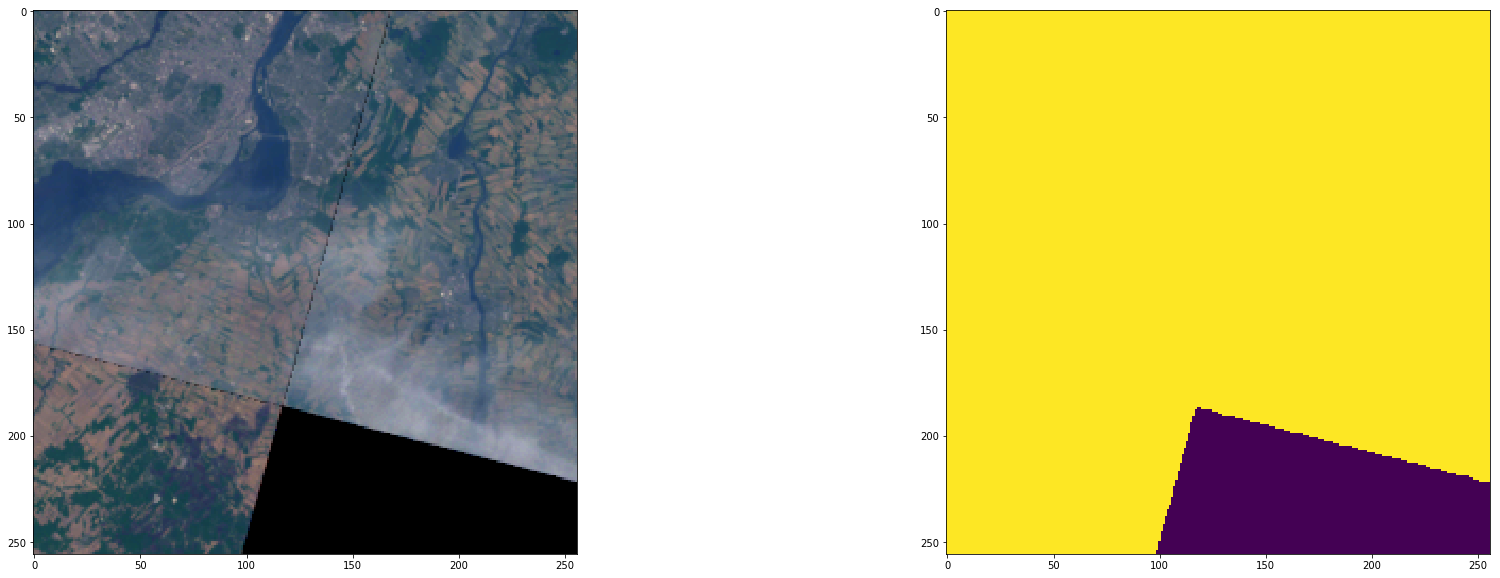

In [17]:
tile, mask = mosaic_tiler(
    assets,
    x,
    y,
    z,
    tiler,
    pixel_selection=defaults.MeanMethod(),
)
tile = tile.astype(np.uint16)

for ops in parse_operations(color_formula):
    tile = scale_dtype(ops(to_math_type(tile)), np.uint8)

fig = figure(figsize=(30, 10))

ax = fig.add_subplot(1, 2, 1)
ax.imshow(reshape_as_image(tile))

ax = fig.add_subplot(1, 2, 2)
ax.imshow(mask)

## Create Custom pixel_selection class 

### 1. Using a 4th band for decision: highest NDVI  

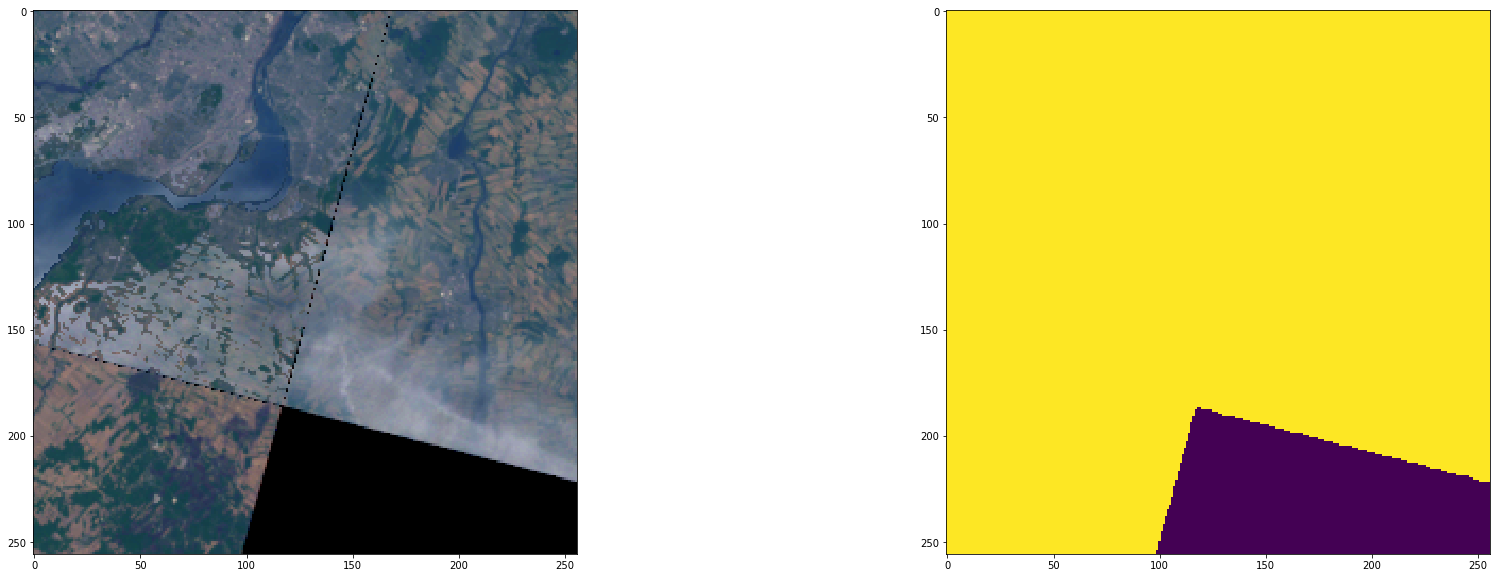

In [38]:
class CustomFourthBandH(MosaicMethodBase):
    """Feed the mosaic tile with the Mean pixel value."""

    @property
    def data(self):
        """Return data and mask."""
        if self.tile is not None:
            return self.tile.data[:-1], ~self.tile.mask[0] * 255
        else:
            return None, None

    def feed(self, tile):
        """Add data to tile."""
        if self.tile is None:
            self.tile = tile
            return

        pidex = (
            numpy.bitwise_and(tile.data[-1] > self.tile.data[-1], ~tile.mask) | self.tile.mask
        )

        mask = numpy.where(pidex, tile.mask, self.tile.mask)
        self.tile = numpy.ma.where(pidex, tile, self.tile)
        self.tile.mask = mask

# Here we use rio-tiler special expression handler to pass bands names and expression
# rio-tiler.expresion will produce a 4band array (b4, b3, b2, ndvi)
expr = "b4,b3,b2,(b5-b4)/(b5+b4)"

tile, mask = mosaic_tiler(
    assets,
    x,
    y,
    z,
    expressionTiler,
    pixel_selection=CustomFourthBandH(),
    expr=expr
)

# Because ndvi is a floating point value 
# (the output from expressionTiler and thus mosaic_tiler) 
# we need to cast the values to uint16
tile = tile.astype(np.uint16)

for ops in parse_operations(color_formula):
    tile = scale_dtype(ops(to_math_type(tile)), np.uint8)

fig = figure(figsize=(30, 10))

ax = fig.add_subplot(1, 2, 1)
ax.imshow(reshape_as_image(tile))

ax = fig.add_subplot(1, 2, 2)
ax.imshow(mask)

### 2. Using a 4th band for decision: highest Band 9 (Cirrus)  

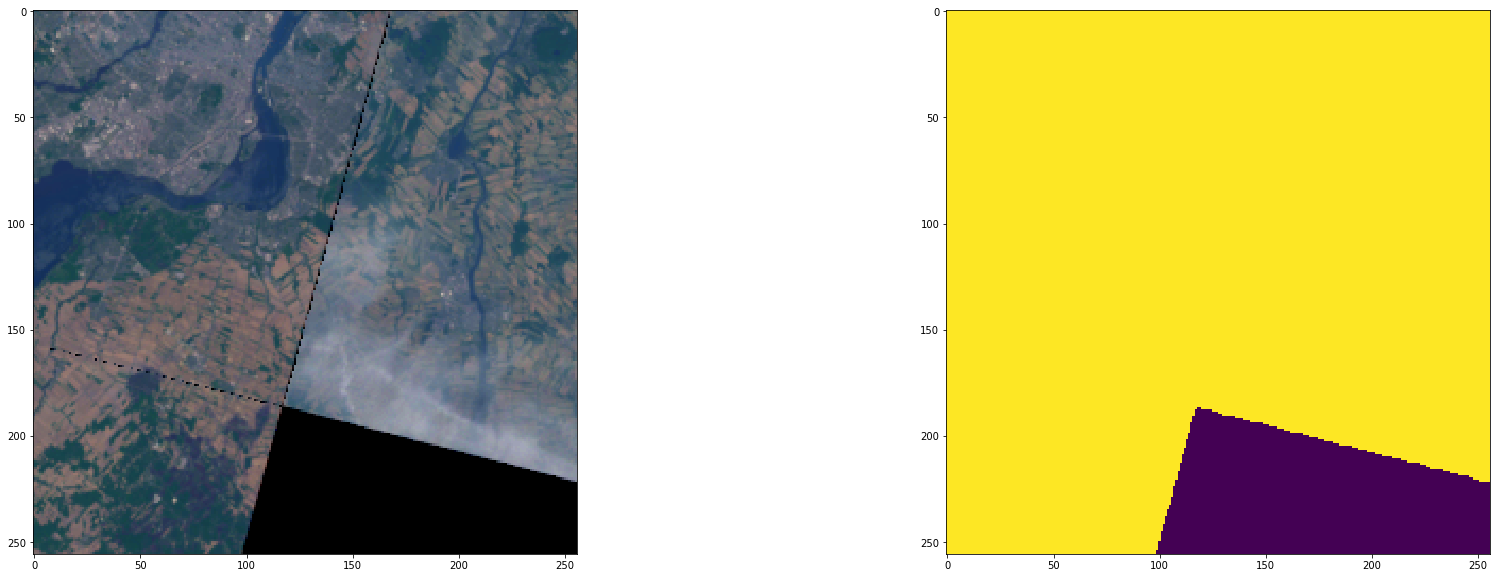

In [45]:
class CustomFourthBandL(MosaicMethodBase):
    """Feed the mosaic tile with the Mean pixel value."""

    @property
    def data(self):
        """Return data and mask."""
        if self.tile is not None:
            # We remove the 4th band
            return self.tile.data[:-1], ~self.tile.mask[0] * 255
        else:
            return None, None

    def feed(self, tile):
        """Add data to tile."""
        if self.tile is None:
            self.tile = tile
            return

        pidex = (
            numpy.bitwise_and(tile.data[-1] < self.tile.data[-1], ~tile.mask) | self.tile.mask
        )

        mask = numpy.where(pidex, tile.mask, self.tile.mask)
        self.tile = numpy.ma.where(pidex, tile, self.tile)
        self.tile.mask = mask


tile, mask = mosaic_tiler(
    assets,
    x,
    y,
    z,
    tiler,
    pixel_selection=CustomFourthBandL(),
    bands=("4", "3", "2", "9"),
)
tile = tile.astype(np.uint16)

for ops in parse_operations(color_formula):
    tile = scale_dtype(ops(to_math_type(tile)), np.uint8)

fig = figure(figsize=(30, 10))

ax = fig.add_subplot(1, 2, 1)
ax.imshow(reshape_as_image(tile))

ax = fig.add_subplot(1, 2, 2)
ax.imshow(mask)